<a href="https://colab.research.google.com/github/drMy5tery/SPR-lab/blob/Lab-2/2448540_Lab2_SPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Exercise 2: Fourier Transform and Frequency Spectrum Analysis of Signals

**Aim:**  
To study the Fourier Transform and analyze the frequency spectrum of different signals (sinusoidal, composite, exponential, and rectangular). Compare their time-domain representation with their frequency-domain characteristics using both the Discrete-Time Fourier Transform (DTFT) (computed numerically on a dense grid) and the Discrete Fourier Transform (DFT) (via FFT).

This notebook contains:
- Question 1: Single sinusoid (time plot, DTFT, DFT)
- Question 2: Composite sinusoid (time plot, DTFT, DFT)
- Question 3: Exponentially decaying signal (time plot, DTFT, DFT, analysis)
- Question 4: Rectangular pulse (time plot, DTFT, DFT, analysis)

Notes:
- Sampling frequency `fs` is used to convert the DTFT frequency (ω in radians/sample) to physical frequency (Hz).
- DTFT is approximated by evaluating the DTFT summation on a fine ω grid.


In [15]:
# Cell 2: imports and plotting defaults
import numpy as np
import matplotlib.pyplot as plt

# Notebook-friendly plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 12


This cell defines global sampling parameters used throughout the lab:
- `fs`: sampling frequency (Hz)
- `T`: total signal duration (s)
- `N`: number of samples
- `t`: time vector in seconds
- `n`: discrete sample indices

It also defines:
- `compute_dtft(x, omega)`: computes the DTFT via direct summation for a finite-length sequence `x` evaluated at the frequency vector `omega` (radians/sample).
- `plot_mag_phase(freq_axis_hz, X, ...)`: helper to plot magnitude (linear or dB) vs frequency in Hz.


In [16]:
# Cell 3: global sampling and helper functions

fs = 1000          # sampling frequency in Hz
T = 1.0            # duration in seconds
N = int(fs * T)    # number of samples
t = np.arange(N) / fs   # time vector (seconds)
n = np.arange(N)        # discrete-time indices

def compute_dtft(x, omega):
    """
    Compute DTFT X(e^{j omega}) for finite-length sequence x[n]
    evaluated at the vector of frequencies 'omega' (radians/sample).
    Returns an array of complex DTFT values (same length as omega).
    """
    # vectorized computation: shape (len(omega), len(n))
    W = np.exp(-1j * np.outer(omega, n))
    X = W.dot(x)
    return X

def plot_mag_phase(freq_axis_hz, X, title='', xlim=None, dB=False):
    """
    Plot magnitude (and phase in inset) against frequency axis in Hz.
    freq_axis_hz: frequencies in Hz
    X: complex spectrum values
    dB: whether to plot magnitude in dB (20*log10)
    """
    mag = np.abs(X)
    if dB:
        mag_plot = 20 * np.log10(mag + 1e-12)
        ylabel = 'Magnitude (dB)'
    else:
        mag_plot = mag
        ylabel = 'Magnitude'
    plt.figure(figsize=(10,4))
    plt.plot(freq_axis_hz, mag_plot)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(ylabel)
    if xlim is not None:
        plt.xlim(xlim)
    plt.grid(True)
    plt.tight_layout()


## Question 1 — Single sinusoid

We will:
(a) Generate a sine wave at 5 Hz sampled at 1000 Hz for 1 second.
(b) Plot the time-domain waveform (full and zoomed view).
(c) Compute the DTFT with a dense frequency grid to approximate the continuous spectrum, and plot magnitude vs frequency (Hz).
(d) Compute the DFT via FFT (with zero-padding) and plot the discrete spectrum centered at zero frequency.


This cell generates a 5 Hz sinusoidal signal `x1` sampled at `fs` for the duration `T`.
The signal is x1[n] = sin(2π f0 t).


In [17]:
# Q1a: generate sine wave (5 Hz)
f0 = 5.0  # frequency in Hz
x1 = np.sin(2 * np.pi * f0 * t)


Plot the time-domain waveform:
- First plot shows the full 1-second waveform so you can see the overall periodicity.
- Second plot zooms into the first 200 ms to easily count cycles (5 Hz => 5 cycles in 1 second, or one cycle every 0.2 seconds).


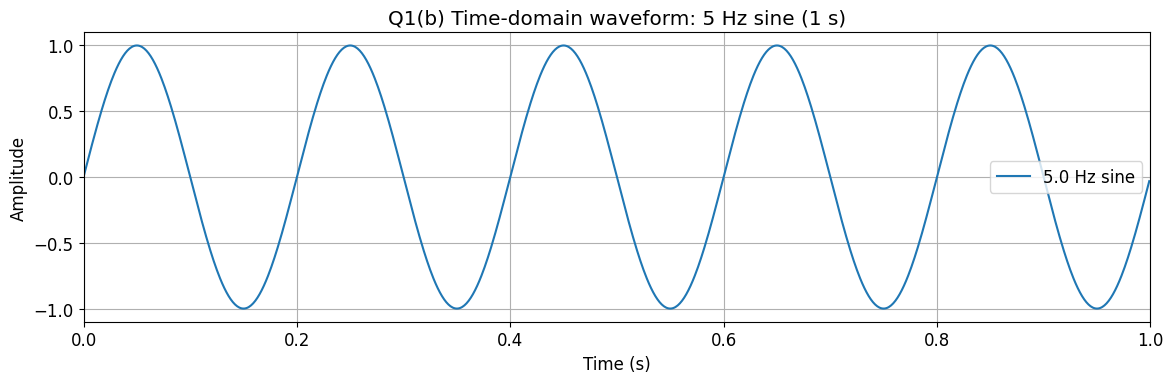

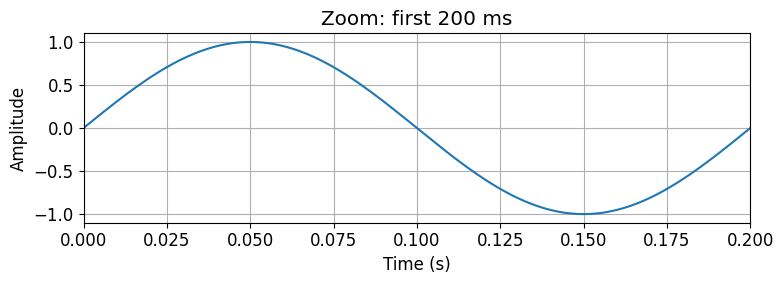

In [18]:
# Q1b: time-domain waveform (full and zoom)
plt.figure(figsize=(12,4))
plt.plot(t, x1, label=f'{f0} Hz sine')
plt.title('Q1(b) Time-domain waveform: 5 Hz sine (1 s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom first 200 ms to see cycles clearly
plt.figure(figsize=(8,3))
plt.plot(t, x1)
plt.xlim(0, 0.2)
plt.title('Zoom: first 200 ms')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


Compute the DTFT on a dense frequency grid:
- We evaluate the DTFT formula via `compute_dtft` at `M` evenly spaced ω values in [-π, π).
- Convert ω (radians/sample) to frequency in Hz using f = (ω / (2π)) * fs for plotting.
- Plot magnitude vs frequency (Hz) around ±50 Hz to highlight the sinusoid peaks at ±5 Hz.


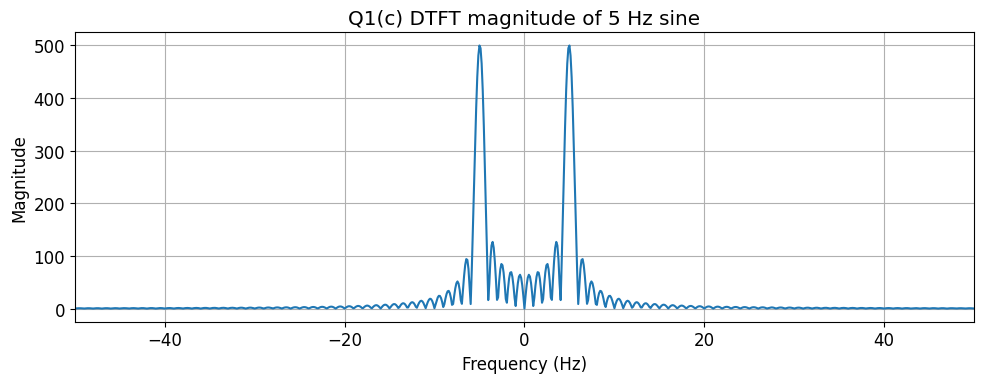

In [19]:
# Q1c: compute DTFT on a dense omega grid
M = 8192  # number of frequency points for DTFT (dense)
omega = np.linspace(-np.pi, np.pi, M, endpoint=False)  # radians/sample
X1_dtft = compute_dtft(x1, omega)

# convert omega -> frequency in Hz: f = (omega / (2*pi)) * fs
freq_hz = omega / (2 * np.pi) * fs

# plot magnitude (linear) around region of interest
plot_mag_phase(freq_hz, X1_dtft, title='Q1(c) DTFT magnitude of 5 Hz sine', xlim=(-50, 50))


Compute the DFT using FFT:
- Use zero-padding (`Nfft`) to increase the density of DFT frequency samples (visual interpolation).
- Use `np.fft.fft` to compute the DFT and `fftshift` to center zero frequency.
- Plot magnitude vs frequency (Hz), show range around ±50 Hz to see peaks at ±5 Hz.
Note: zero-padding does not increase fundamental resolution; it interpolates the DFT.


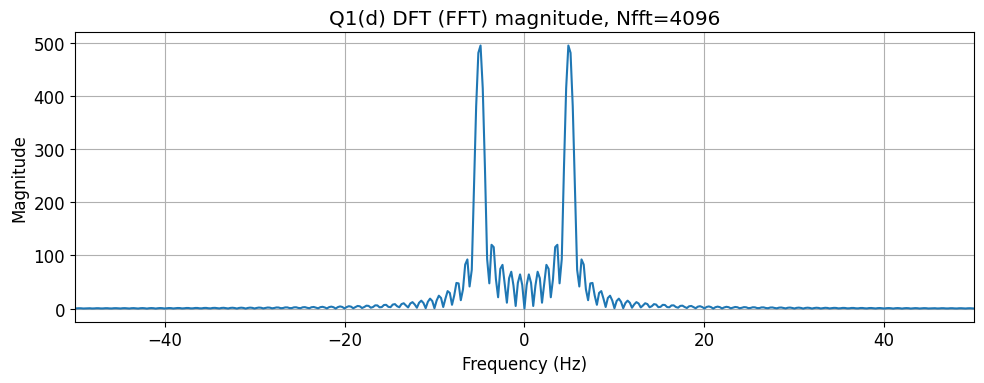

In [20]:
# Q1d: compute DFT using FFT and plot discrete bins
Nfft = 4096  # FFT length (zero-padding increases frequency sampling of DFT)
X1_fft = np.fft.fftshift(np.fft.fft(x1, n=Nfft))
freqs_fft = np.linspace(-fs/2, fs/2, Nfft, endpoint=False)

plot_mag_phase(freqs_fft, X1_fft, title=f'Q1(d) DFT (FFT) magnitude, Nfft={Nfft}', xlim=(-50,50))


**Q1 Analysis / Observations**

- Time-domain: The 5 Hz sinusoid completes 5 cycles in 1 second. Zooming to 200 ms shows exactly one cycle for a 5 Hz tone.
- DTFT: Two sharp peaks at +5 Hz and -5 Hz (in continuous-like DTFT plot). For a pure sinusoid, the DTFT consists of impulses at ±f0 (modulo sampling).
- DFT: Discrete bins centered at zero frequency; with sufficient zero-padding the peaks appear narrow near ±5 Hz. If a sinusoid frequency does not align exactly with a DFT bin, spectral leakage will spread energy across neighboring bins.


## Question 2 — Composite sinusoid

We will:
(a) Generate a composite signal by adding two sinusoids with different frequencies and amplitudes.
(b) Plot the time-domain waveform (full and zoomed).
(c) Compute the DTFT with a dense ω grid and plot the continuous-like spectrum.
(d) Compute the DFT via FFT (zero-padded) and plot the discrete spectrum.


Generate a composite signal `x2` that is the sum of:
- a 5 Hz sinusoid with amplitude 1.0, and
- a 40 Hz sinusoid with amplitude 0.6 and a phase offset π/4.
This demonstrates multi-tone signals and how their frequency components appear in the spectrum.


In [21]:
# Q2a: composite signal (two sinusoids)
f1 = 5.0     # Hz
A1 = 1.0
f2 = 40.0    # Hz
A2 = 0.6
phase2 = np.pi/4  # a phase offset for second tone

x2 = A1 * np.sin(2*np.pi*f1*t) + A2 * np.sin(2*np.pi*f2*t + phase2)


Plot the composite signal in time domain:
- Full 1-second plot to see both tones combined.
- Zoom into the first 200 ms to see the faster 40 Hz oscillation riding on the slower 5 Hz envelope.


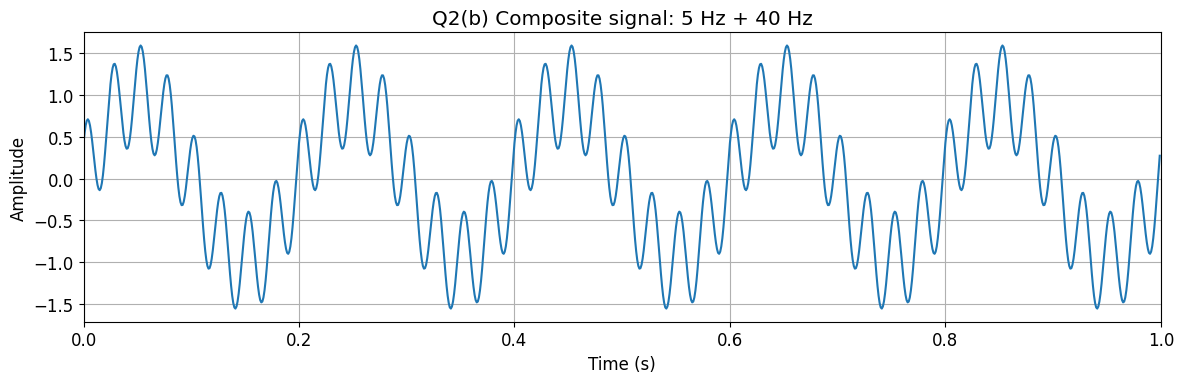

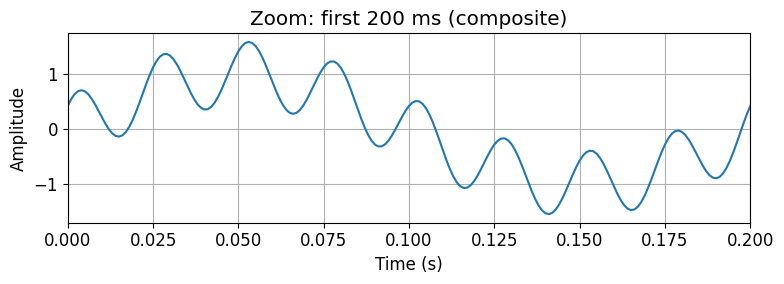

In [22]:
# Q2b: plot composite signal (full and zoom)
plt.figure(figsize=(12,4))
plt.plot(t, x2)
plt.title('Q2(b) Composite signal: 5 Hz + 40 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# zoom into first 200 ms to see beating/waveform shape
plt.figure(figsize=(8,3))
plt.plot(t, x2)
plt.xlim(0, 0.2)
plt.title('Zoom: first 200 ms (composite)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


Compute the DTFT of the composite signal on a dense ω grid and plot magnitude vs frequency (Hz).
Expect to see peaks at ±5 Hz and ±40 Hz. The relative peak heights should roughly reflect the amplitude ratio, subject to FFT/DTFT scaling conventions.


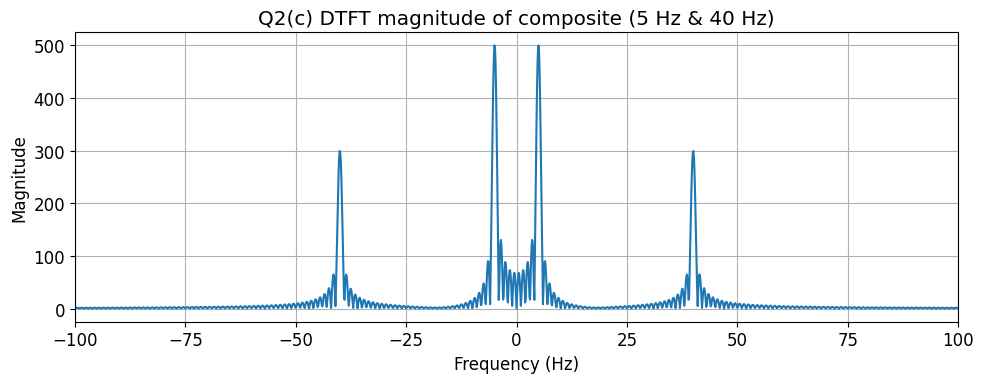

In [23]:
# Q2c: DTFT of composite
M = 8192
omega = np.linspace(-np.pi, np.pi, M, endpoint=False)
X2_dtft = compute_dtft(x2, omega)
freq_hz = omega / (2 * np.pi) * fs

plot_mag_phase(freq_hz, X2_dtft, title='Q2(c) DTFT magnitude of composite (5 Hz & 40 Hz)', xlim=(-100,100))


Compute the DFT (FFT) of the composite signal:
- Use zero-padding (`Nfft`) for denser frequency bin sampling (visual interpolation).
- Plot magnitude vs frequency (Hz) showing peaks for the two tones at ±5 Hz and ±40 Hz.


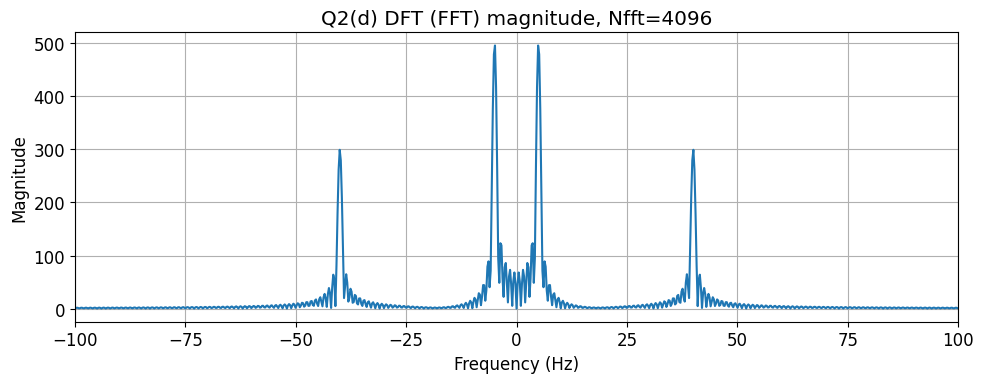

In [24]:
# Q2d: DFT (FFT) for composite
Nfft = 4096
X2_fft = np.fft.fftshift(np.fft.fft(x2, n=Nfft))
freqs_fft = np.linspace(-fs/2, fs/2, Nfft, endpoint=False)

plot_mag_phase(freqs_fft, X2_fft, title=f'Q2(d) DFT (FFT) magnitude, Nfft={Nfft}', xlim=(-100,100))


**Q2 Analysis / Observations**

- Two dominant spectral peaks should appear at ±5 Hz and ±40 Hz.
- If a tone's frequency does not fall on a DFT bin exactly, its energy will leak into adjacent bins (spectral leakage). Zero-padding makes the DFT appear smoother but does not increase intrinsic resolution.
- Peak heights reflect the relative amplitude of each sinusoidal component (up to scaling).


## Question 3 — Exponentially decaying signal

We will:
(a) Generate an exponentially decaying signal sampled at `fs`.
(b) Plot its time-domain waveform.
(c) Compute the DTFT numerically and compare with the analytic DTFT for the discrete-time exponential `r^n u[n]`.
(d) Compute the DFT via FFT and plot the discrete spectrum.
(e) Discuss the relationship: faster decay in time ↔ broader frequency spectrum.


Generate a sampled exponential x3[n] = exp(-a * t[n]) for t = n/fs.
From discrete-time viewpoint, this corresponds to x3[n] = r^n where r = exp(-a/fs). We print r to show the discrete equivalent decay per sample.


In [25]:
# Q3a: exponentially decaying signal
a = 5.0                    # decay rate (per second)
x3 = np.exp(-a * t)        # samples of continuous-time exp(-a t)
# Note: x3[n] = (r**n) with r = exp(-a/fs), so DTFT known analytically for n>=0

# Also compute r for discrete-time viewpoint
r = np.exp(-a / fs)
print(f"Discrete-time equivalent r = exp(-a/fs) = {r:.6f}")


Discrete-time equivalent r = exp(-a/fs) = 0.995012


Plot the exponential decay in the time domain across the 1 second interval. With a=5, the signal decays rapidly (value at t=1 will be exp(-5) ≈ 0.0067).


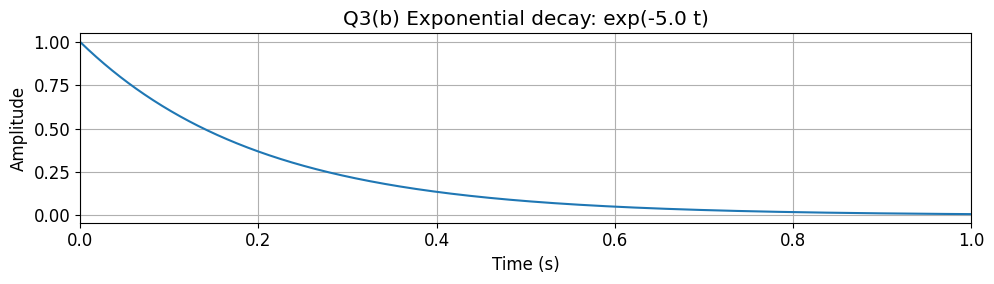

In [26]:
# Q3b: time-domain plot
plt.figure(figsize=(10,3))
plt.plot(t, x3)
plt.title(f'Q3(b) Exponential decay: exp(-{a} t)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


Compute the DTFT numerically and compare it to the analytic DTFT formula for the causal discrete exponential x[n] = r^n u[n], which is X(e^{jω}) = 1 / (1 - r e^{-jω}) (for |r| < 1). We plot numeric vs analytic magnitudes over a frequency range to verify agreement.


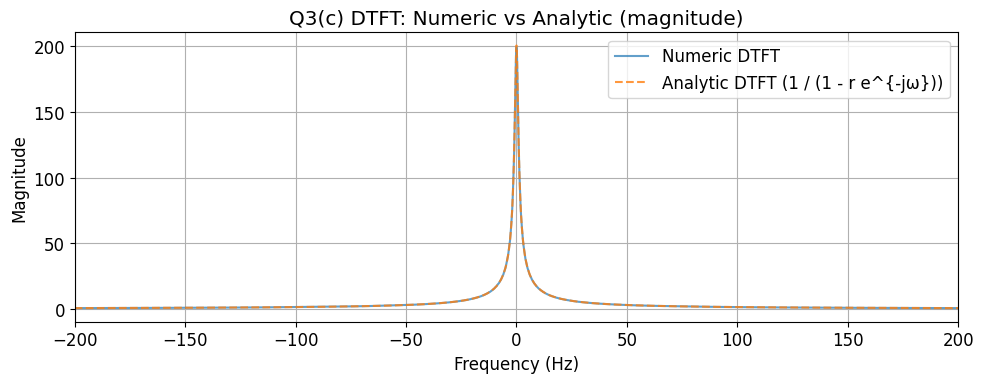

In [27]:
# Q3c: DTFT numeric
M = 8192
omega = np.linspace(-np.pi, np.pi, M, endpoint=False)
X3_dtft_num = compute_dtft(x3, omega)
freq_hz = omega / (2 * np.pi) * fs

# analytic DTFT (discrete-time r^n u[n]) formula: X(omega) = 1 / (1 - r * e^{-j*omega})
X3_dtft_analytic = 1.0 / (1.0 - r * np.exp(-1j * omega))

# Plot numeric vs analytic magnitudes
plt.figure(figsize=(10,4))
plt.plot(freq_hz, np.abs(X3_dtft_num), label='Numeric DTFT', alpha=0.7)
plt.plot(freq_hz, np.abs(X3_dtft_analytic), '--', label='Analytic DTFT (1 / (1 - r e^{-jω}))', alpha=0.8)
plt.title('Q3(c) DTFT: Numeric vs Analytic (magnitude)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-200, 200)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Compute the DFT of the exponential using FFT (with zero-padding for smoother plotting). Plot the DFT magnitude to visualize the spectrum centered at zero frequency.


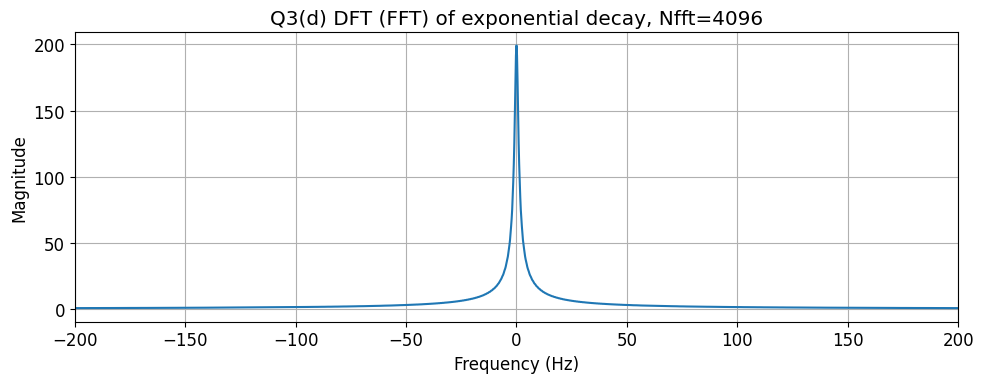

In [28]:
# Q3d: DFT using FFT
Nfft = 4096
X3_fft = np.fft.fftshift(np.fft.fft(x3, n=Nfft))
freqs_fft = np.linspace(-fs/2, fs/2, Nfft, endpoint=False)

plot_mag_phase(freqs_fft, X3_fft, title=f'Q3(d) DFT (FFT) of exponential decay, Nfft={Nfft}', xlim=(-200,200))


**Q3 Analysis / Observations**

- Time-domain: exponential decay is concentrated near n = 0; amplitude decays quickly.
- Frequency-domain: fast decay (short in time) → broad frequency content (wide main lobe). Slow decay → narrow band around DC.
- Analytic DTFT `X(e^{jω}) = 1 / (1 - r e^{-jω})` explains the shape: a magnitude peak at ω = 0 and bandwidth determined by r (or equivalently a).
- This demonstrates the time-frequency tradeoff: short-lived signals have wide spectra.


## Question 4 — Rectangular pulse

We will:
(a) Generate a finite-duration rectangular pulse of specified length, centered in the 1-second window.
(b) Plot the time-domain pulse.
(c) Compute the DTFT numerically and compare it to the analytic sinc-like expression.
(d) Compute the DFT via FFT and plot the discrete spectrum.
(e) Discuss the rectangular ↔ sinc relationship and the time-frequency tradeoff.


Generate a rectangular pulse of duration `pulse_duration` seconds. Convert duration to sample length L = pulse_duration * fs, create an N-length vector `x4` with ones from `start` to `end-1` centered in the time window, zeros elsewhere. Print L and indices for clarity.


In [29]:
# Q4a: rectangular pulse
pulse_duration = 0.1  # seconds
L = int(pulse_duration * fs)  # pulse length in samples
x4 = np.zeros(N)
center = N // 2
start = center - L // 2
end = start + L
x4[start:end] = 1.0

print(f"Pulse length L = {L} samples ({L/fs} s). Pulse indices {start} to {end-1}.")


Pulse length L = 100 samples (0.1 s). Pulse indices 450 to 549.


Plot the rectangular pulse in the time domain, zoomed around the pulse center so the rectangular shape is clearly visible. Use a 'steps-post' style to emphasize the discrete sample values.


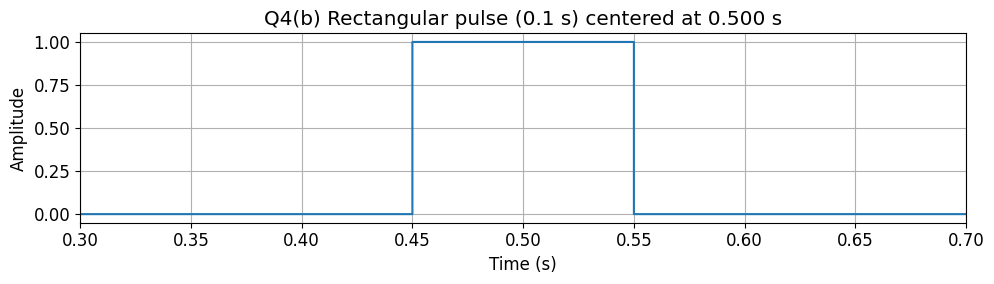

In [30]:
# Q4b: plot rectangular pulse
plt.figure(figsize=(10,3))
plt.plot(t, x4, drawstyle='steps-post')
plt.title(f'Q4(b) Rectangular pulse ({pulse_duration} s) centered at {center/fs:.3f} s')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim((center/fs) - 0.2, (center/fs) + 0.2)  # zoom around center
plt.tight_layout()
plt.show()


Compute numeric DTFT of the rectangular pulse and compare it to an analytic sinc-like approximation:
- The analytic expression for a centered rectangular pulse has magnitude proportional to |sin(ω L / 2) / sin(ω / 2)|.
- We compute `X4_dtft` using `compute_dtft` and plot numeric vs analytic magnitudes to show the sinc envelope and zeros at predictable frequencies.


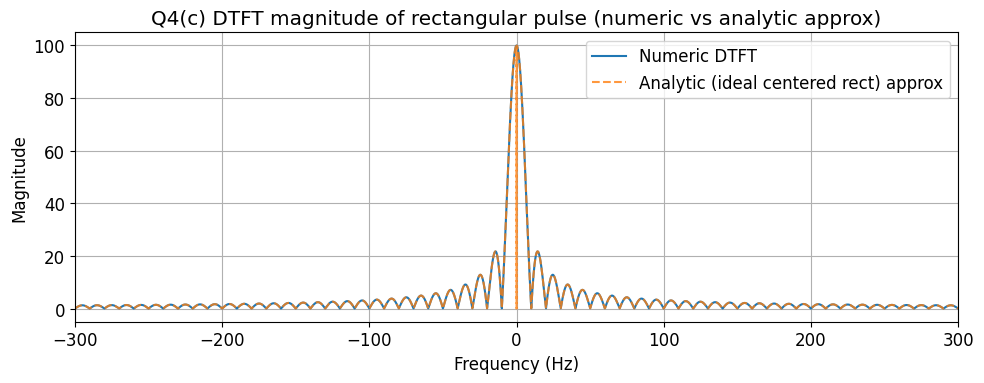

In [31]:
# Q4c: DTFT of rectangular pulse (numeric)
M = 8192
omega = np.linspace(-np.pi, np.pi, M, endpoint=False)
X4_dtft = compute_dtft(x4, omega)
freq_hz = omega / (2 * np.pi) * fs

# analytic DTFT for a centered rectangular pulse of length L:
# For a pulse with ones from n = -L/2 to L/2-1 (centered), DTFT magnitude ~ |sin(omega*L/2) / sin(omega/2)|
# Our pulse is centered in an N-length window; the phase shift is e^{-j omega (L-1)/2} approximately.
# We'll compute the ideal centered-rectangle formula for direct comparison:
omega_shift = omega
# Avoid division by zero using sinc-like handling
den = np.sin(omega_shift / 2)
num = np.sin(omega_shift * L / 2)
# handle small denom numerically
den_safe = den.copy()
den_safe[np.abs(den_safe) < 1e-12] = 1e-12
X4_analytic = num / den_safe * np.exp(-1j * omega_shift * (L - 1) / 2)

plt.figure(figsize=(10,4))
plt.plot(freq_hz, np.abs(X4_dtft), label='Numeric DTFT')
plt.plot(freq_hz, np.abs(X4_analytic), '--', label='Analytic (ideal centered rect) approx', alpha=0.8)
plt.title('Q4(c) DTFT magnitude of rectangular pulse (numeric vs analytic approx)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-300, 300)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Compute the DFT via FFT with zero-padding for smoother visualization:
- Use a large `Nfft` to sample the DFT densely and plot magnitude vs frequency (Hz).
- The DFT should reflect the sinc-shaped envelope with zeros spaced inversely to the pulse length.


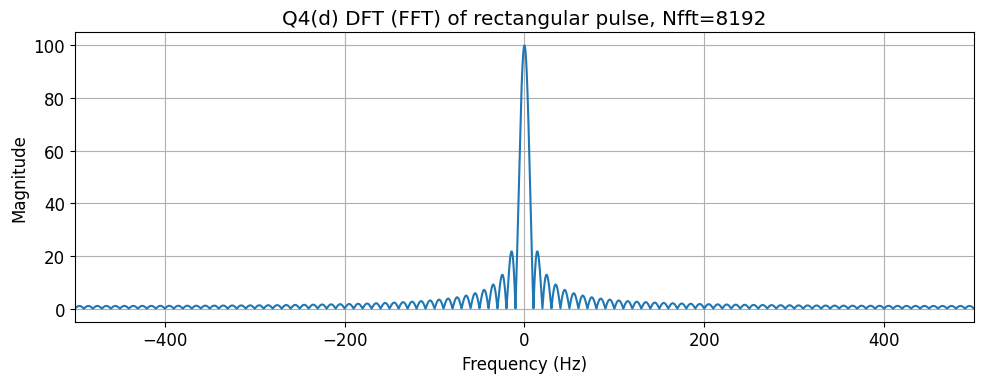

In [32]:
# Q4d: DFT (FFT)
Nfft = 8192
X4_fft = np.fft.fftshift(np.fft.fft(x4, n=Nfft))
freqs_fft = np.linspace(-fs/2, fs/2, Nfft, endpoint=False)

plot_mag_phase(freqs_fft, X4_fft, title=f'Q4(d) DFT (FFT) of rectangular pulse, Nfft={Nfft}', xlim=(-500,500))


**Q4 Analysis / Observations**

- The rectangular pulse in time corresponds to a sinc-shaped frequency-domain magnitude envelope.
- Main-lobe width is inversely proportional to pulse length: longer pulse → narrower main lobe (more concentrated in frequency).
- Zeros in frequency appear at ω where sin(ω L / 2) = 0, i.e., spaced by fs / L in physical frequency.
- This is a clear demonstration of time-frequency duality: time-limited signals have broad (infinite) frequency support with sinc-shaped shapes.


## Summary & Practical Notes

- **DTFT vs DFT**: The DTFT is a continuous function of frequency for finite-length sequences; we approximate it numerically on a dense ω grid. The DFT/FFT returns discrete samples of the DTFT at frequencies determined by the FFT length and sampling frequency.
- **Zero-padding**: Increasing `Nfft` (zero-padding) increases the number of plotted frequency samples (interpolation) but does not increase the fundamental frequency resolution imposed by the signal duration.
- **Spectral leakage**: If a sinusoid's frequency doesn't align with DFT bins, energy spreads into neighboring bins. Windowing reduces leakage but widens the main lobe.
- **Time-frequency tradeoff**: Short time signals (pulses, rapid decay) ↔ wide frequency spectra. Long signals ↔ concentrated frequency content.
- **Useful experiments**: change `Nfft`, `M`, apply windows (Hamming/Hann) to observe leakage vs resolution trade-offs.


Optional: Save plots or data. The following code cell provides an example of saving the last DFT result figure as a PNG file. You can modify the filename or save other arrays to disk as needed.


Saved rect_pulse_dft_magnitude.png


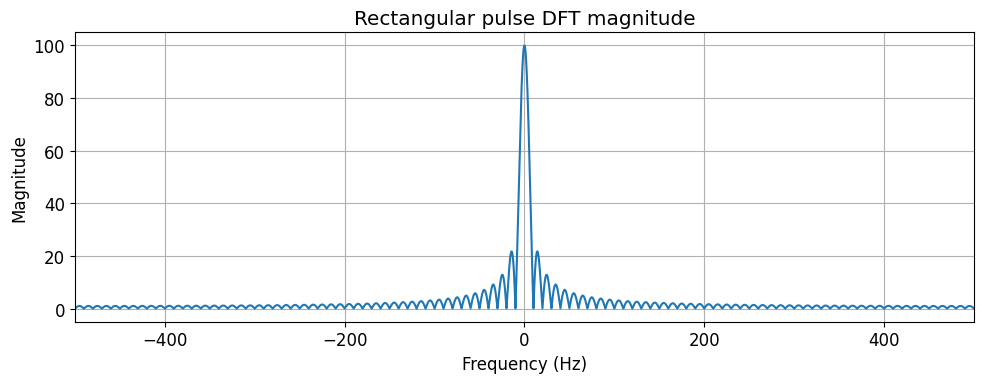

In [33]:
# Example: save the last DFT result figure to file
plt.figure(figsize=(10,4))
plt.plot(freqs_fft, np.abs(X4_fft))
plt.title('Rectangular pulse DFT magnitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-500,500)
plt.grid(True)
plt.tight_layout()
plt.savefig('rect_pulse_dft_magnitude.png', dpi=200)
print("Saved rect_pulse_dft_magnitude.png")
